# Package management

In [1]:
# Import modules
import importlib
import tensorflow as tf
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
from gyoza.modelling import flow_layers as mfl
from gyoza.modelling import masks as gmm
from gyoza.modelling import standard_layers as msl
from gyoza.utilities import math as gum
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import List
from gyoza.modelling import data_iterators as mdis
import shutil
import random
plt.rcParams["font.family"] = "Times New Roman"

2023-07-21 11:33:32.408129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reload custom modules
importlib.reload(mfl)
importlib.reload(gmm)
importlib.reload(msl)
importlib.reload(gum)
importlib.reload(mdis)

<module 'gyoza.modelling.data_iterators' from '/Users/timdick/Documents/gyoza/gyoza/src/gyoza/modelling/data_iterators.py'>

# Configuration

In [3]:
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
def reset_random_number_generators(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# Data Synthesis

A batch has shapes:
X_a_b: (instances, pair, coordinates) (3, 2, 2)
Y_a_b: (instances, factors)           (3, 2)


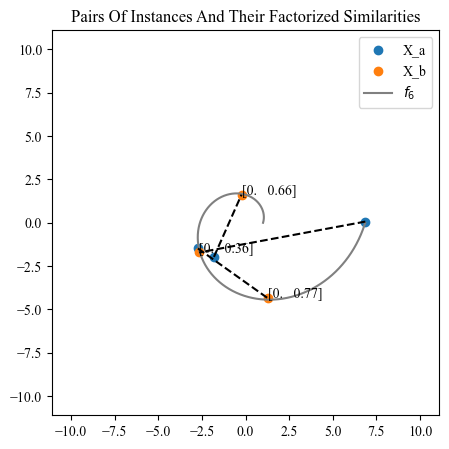

In [57]:
# Create manifolds

# 0. Ensure reproducability
reset_random_number_generators(seed=42)

# 1. Generate equally spaced points along a line of length S
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
S = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
s = np.linspace(-S/2,S/2,1000, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold

# 2. Create mathematical functions that map step s along an arc to x and y coordinates
f_1 = lambda s: (np.arcsinh(s), np.sign(np.arcsinh(s)) * np.cosh(np.arcsinh(s)) - np.sign(s))
f_2 = lambda s: gum.rotate(xs=s, ys=0*s, theta=np.arccos((f_1(S/2)[1]/ f_1(S/2)[0]) / np.sqrt(f_1(S/2)[0]**2 + f_1(S/2)[1]**2))) # this theta leads to same slope as the cosh function on s

f_3 = lambda s: (s, S*np.sign(s)/4)
def f_4(s):
    half_1 = s[np.where(s <  0)]
    half_2 = s[np.where(0 <= s)]

    x_1 = np.concatenate([half_1, half_2 - S/4]) + 1*S/8
    x_2 = np.array([1*S/4]* len(half_1) + [3*S/4] * len(half_2)) - S/2

    return x_1, x_2

f_5 = lambda s: ((S/(2*np.pi))* np.sin((s+S/2)*(2*np.pi)/S), (S/(2*np.pi))*np.cos((s+S/2)*(2*np.pi)/S))
f_6 = lambda s: gum.logarithmic_spiral(xs=np.log((s+S/2)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

manifold_functions = {'f_1':f_1, 'f_2':f_2, 'f_3':f_3, 'f_4':f_4, 'f_5':f_5, 'f_6':f_6}

# 3. Select a manifold
manifold_name = 'f_6'
manifold_function_raw = manifold_functions[manifold_name]

# 4. Add noise
noise_strength = 0.3
noise_function = lambda x_1, x_2: (x_1 + noise_strength * np.random.standard_normal(size=x_1.shape), x_2 + noise_strength * np.random.standard_normal(size=x_2.shape))
manifold_function = lambda x: noise_function(*manifold_function_raw(x))

# 5. Generate data
Y = np.concatenate([np.zeros([len(s),1]), s[:, np.newaxis]], axis=1) # Here the first dimension is zero because deviation from the manifold is pushed to the residual factor. The second dimension is the step along the manifold 
x_1, x_2 = manifold_function(s) # Map onto manifold in 2D plane
X = np.concatenate([x_1[:,np.newaxis], x_2[:,np.newaxis]], axis=1); del x_1, x_2

# 6. Choose a data iterator
similarity_function = lambda y_a, y_b: np.concatenate([np.zeros([y_a.shape[0],1]), 1 - np.abs(y_a[:,1:2]-y_b[:,1:2])/S], axis=1)
iterator = mdis.volatile_factorized_pair_iterator(X=X, Y=Y, batch_size=3, similarity_function=similarity_function)
X_a_b, Y_a_b = next(iterator)
print("A batch has shapes:")
print("X_a_b: (instances, pair, coordinates)", X_a_b.shape)
print("Y_a_b: (instances, factors)          ", Y_a_b.shape)

# 7. Plot instances
plt.figure(figsize=(5,5)); plt.title("Pairs Of Instances And Their Factorized Similarities")
    
plt.scatter(X_a_b[:,0,0], X_a_b[:,0,1]) # Instances a
plt.scatter(X_a_b[:,1,0], X_a_b[:,1,1]) # Instances b

#for i in range(len(s)-1): plt.scatter(*manifold_function_raw(s[i:i+2]), color='gray', marker='.')
plt.plot(*manifold_function_raw(s), color='gray')#, marker='.')

plt.legend(['X_a','X_b',rf'${manifold_name}$'])
for i in range(X_a_b.shape[0]):
    plt.plot([X_a_b[i,0,0], X_a_b[i,1,0]], [X_a_b[i,0,1], X_a_b[i,1,1]], '--', color='black')
    plt.text(X_a_b[i,1,0], X_a_b[i,1,1], str(np.round(Y_a_b[i], 2)))
plt.ylim(-S/1.8,S/1.8); plt.xlim(-S/1.8,S/1.8)
plt.show()

# Model Creation

In [58]:
def create_network(seed) -> mfl.FlowLayer:
    reset_random_number_generators(seed=seed)
    dimensionality = 2
    compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_1 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_2 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_3 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_3 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_4 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_4 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    
    network = mfl.SupervisedFactorNetwork(sequence=[
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.Reflection(axes=[1], shape=[dimensionality], reflection_count=2),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_3, mask=mask_3), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_4, mask=mask_4), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.ActivationNormalization(axes=[1], shape=[dimensionality])
        ],
        dimensions_per_factor=[1,1]) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)

    return network

network = create_network(62) #60, 61

network(X_a_b[:,0,:]) # Pass a representative sample through the network. Needed for initialization of some layers
print("For the these 3 X_a input instances:")
print(X_a_b[:3,0,:]) # 0 selects X_a
print("\nthe model provides this initial decomposition ")
print(network(X_a_b[:3,0,:])) # 0 selects X_a
print("\nand this is the reconstruction error (should be almost 0)")
print(network.invert(network(X_a_b[:3,0,:])) - X_a_b[:3,0,:])  # 0 selects X_a


For the these 3 X_a input instances:
tf.Tensor(
[[-1.81577727 -1.96995906]
 [ 6.86171525  0.06864957]
 [-2.73360134 -1.48054351]], shape=(3, 2), dtype=float64)

the model provides this initial decomposition 
tf.Tensor(
[[-0.34791973 -0.72844002]
 [ 1.36106302  1.41399682]
 [-1.01314329 -0.6855568 ]], shape=(3, 2), dtype=float64)

and this is the reconstruction error (should be almost 0)
tf.Tensor(
[[ 8.88178420e-16  8.88178420e-16]
 [-8.88178420e-16  2.22044605e-16]
 [ 4.44089210e-16  2.22044605e-16]], shape=(3, 2), dtype=float64)


# Model Calibration

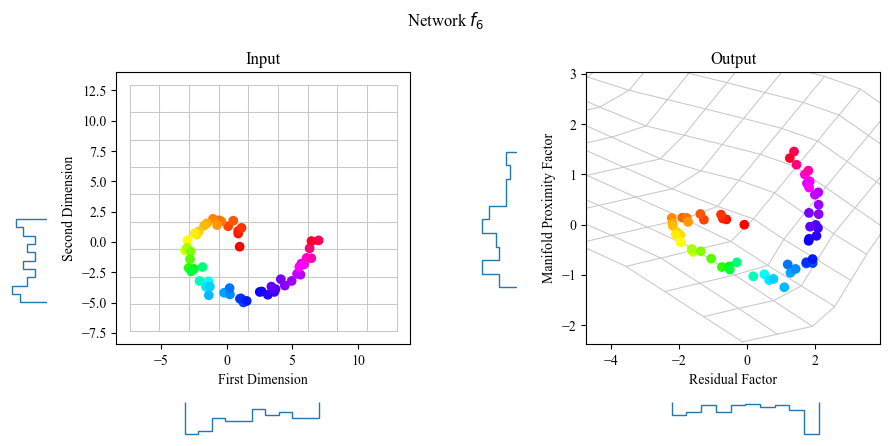

In [59]:
def plot_input_output(network, s_range, f, title):
    # Sample from manifold to illustrate distortion of data
    s = np.linspace(s_range[0], s_range[1], len(gum.color_palette)) # Each point will receive its own color
    x_1, x_2 = f(s)
    
    # Create gridlines to illustrate distortion of surrounding space
    points_per_line = 10
    min_x_1 = np.min(x_1); max_x_1 = np.max(x_1); mean_x_1 = np.abs(np.mean(x_1))
    min_x_2 = np.min(x_2); max_x_2 = np.max(x_2); mean_x_2 = np.abs(np.mean(x_2))
    
    if (np.abs(max_x_1 - min_x_1) < np.abs(max_x_2 - min_x_2)):
        x_2_grid = np.linspace(min_x_2 - np.abs(mean_x_2 - min_x_2), max_x_2 + np.abs(mean_x_2-max_x_2), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_2_grid, x_2_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_2_grid, x_2_grid) # vertical line coordinates
    else:
        
        x_1_grid = np.linspace(min_x_1 - np.abs(mean_x_1-min_x_1), max_x_1 + np.abs(mean_x_1-max_x_1), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_1_grid, x_1_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_1_grid, x_1_grid) # vertical line coordinates

    # Plot
    fig, axs = plt.subplots(2,4,figsize=(9,4.5), gridspec_kw={'height_ratios': [4, 0.5], 'width_ratios':[0.5,4,0.5,4]})
    # X
    # Plot joint distributions
    plt.suptitle(title)
    plt.subplot(2,4,2); plt.title("Input")
    # Gridlines
    for l in range(points_per_line): plt.plot(h_x_1[l,:], h_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(v_x_1[l,:], v_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    # Data
    plt.scatter(x_1, x_2, c=gum.color_palette/255.0, zorder=3); plt.xlabel("First Dimension"); plt.ylabel("Second Dimension")
    X_x_lim = plt.gca().get_xlim(); X_y_lim = plt.gca().get_ylim() # Use these for marginal distributions
    
    # Z
    plt.subplot(2,4,4); plt.title("Output")
    Z = network(tf.concat([x_1[:,np.newaxis], x_2[:,np.newaxis]], axis=1))
    H_z = network(tf.concat([np.reshape(h_x_1, [-1])[:,np.newaxis], np.reshape(h_x_2, [-1])[:,np.newaxis]], axis=1))
    V_z = network(tf.concat([np.reshape(v_x_1, [-1])[:,np.newaxis], np.reshape(v_x_2, [-1])[:,np.newaxis]], axis=1))
    
    # Gridlines
    for l in range(points_per_line): plt.plot(H_z[l*points_per_line:(l+1)*points_per_line,0], H_z[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(V_z[l*points_per_line:(l+1)*points_per_line,0], V_z[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    # Data
    plt.scatter(Z[:,0], Z[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel('Residual Factor'); plt.ylabel('Manifold Proximity Factor')
    Z_min = np.min(Z, axis=0); Z_max = np.max(Z, axis=0); Z_mean = np.mean(Z, axis=0)
    Z_x_lim = (Z_min[0] - np.abs(Z_mean[0] - Z_min[0]), Z_max[0] + np.abs(Z_mean[0] - Z_max[0])); 
    Z_y_lim = (Z_min[1] - np.abs(Z_mean[1] - Z_min[1]), Z_max[1] + np.abs(Z_mean[1] - Z_max[1])); 
    plt.xlim(*Z_x_lim); plt.ylim(*Z_y_lim)
    
    # Plot marginal distributions
    # X
    plt.subplot(2,4,6)
    plt.hist(x_1, histtype='step'); plt.xlim(X_x_lim); plt.gca().invert_yaxis(); plt.axis('off')
    plt.subplot(2,4,1)
    plt.hist(x_2, orientation='horizontal', histtype='step'); plt.ylim(X_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # Z
    plt.subplot(2,4,8)
    plt.hist(Z[:,0], histtype='step'); plt.gca().invert_yaxis(); plt.xlim(Z_x_lim); plt.axis('off')
    plt.subplot(2,4,3)
    plt.hist(Z[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # Make other subplots invisible
    plt.subplot(2,4,5); plt.axis('off')
    plt.subplot(2,4,7); plt.axis('off')

    plt.tight_layout()
    plt.show() 
 
plot_input_output(network, s_range = [np.min(s), np.max(s)], f=manifold_function, title="Network " + r"${}$".format(manifold_name))

In [60]:
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05))
epoch_count = 50
batch_size = 512
reset_random_number_generators(78)
for e in range(epoch_count):
    iterator = mdis.volatile_factorized_pair_iterator(X=X, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
    for batch in iterator:
        loss = network.train_step(data=batch)
        print(loss.numpy())
        

7.31126602660445
6.8671187555689
6.579697732440858
6.512269823308102
6.326043396473435
6.345392862731947
6.368359586306594
6.345902864083866
6.296170687732941
6.305600597548971
6.2667753377352335
6.27707452729843
6.24001773903273
6.2459497121521474
6.213243739767613
6.200252384604854
6.157758465248882
6.143523562932464
6.090250460253109
6.069715416861205
6.083757129177991
6.019632746716703
5.991742666147845
5.9050951263726725
5.806025825581303
5.760945753567542
5.730709506240982
5.5871541832553095
5.483638021117252
5.368985333261806
5.526687709624074
5.27876245020728
5.0762526379176665
5.081730282061416
5.544829354278043
7.117312828085017
5.393003775036468
7.216906399751233
4.963514964475455
6.144322832453862
6.255198363117493
4.953787975932964
5.472101980690106
5.829299827633524
5.0512076931020475
5.311166457541692
5.654884190163832
5.537259510542843
5.1298598884824855
5.207149449852511
5.350511731633776
5.3683835383235285
5.175157971382909
5.094078684732311
5.2801385532550915
5.30637

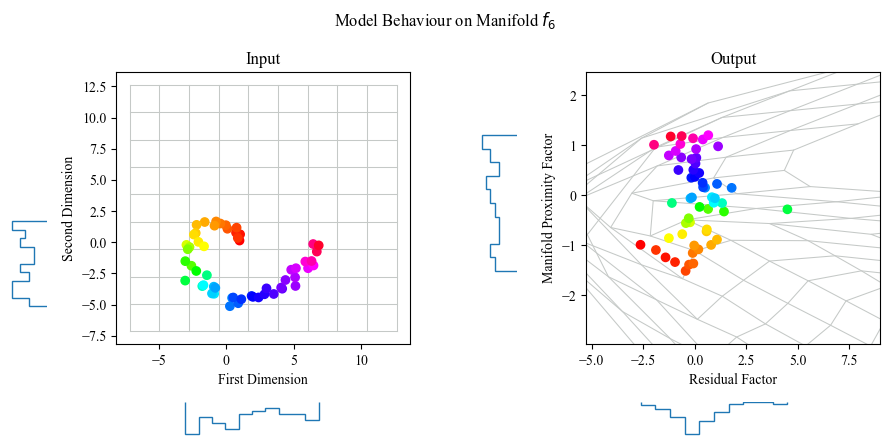

In [61]:
plot_input_output(network, s_range = [np.min(s), np.max(s)], f=manifold_function, title="Model Behaviour on Manifold " + r"${}$".format(manifold_name))

# Model Testing

# Model Saving

xx -2rxy + yy = (y-rx)(y-rx) = yy - yrx -rxy +rrxx = yy -2rxy + xxrr